### Banka, müşterilerinin demografik özelliklerini, gelirlerini, kredi kartı kullanımlarını ve diğer finansal bilgilerini içeren bir veri seti topladı.

### Bu veri setini kendimiz oluşturacağımız için aykırı ve eksik gözlem analizi yapabilmek adına aykırı ve eksik gözlemleri de kendimiz oluşturacağız.

# Veri Setinin Oluşturulması

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [49]:
# veri setini oluşturma

np.random.seed(42)

age = np.random.randint(18, 65, size=1000)
gender = np.random.choice(['male', 'female'], size=1000)
income = np.random.normal(50000, 10000, size=1000)
credit_score = np.random.normal(700, 50, size=1000)
credit_score_usage = np.random.normal(5000, 2000, size=1000)
savings_balance = np.random.normal(20000, 5000, size=1000)

data = pd.DataFrame({
    'age':age, 'gender':gender, 'income':income,
    'credit_score':credit_score, 'credit_card_usage':credit_score_usage,
    'savings_balance':savings_balance
})

data.head()

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,56,male,44448.004733,638.522520,6738.309185,23357.655859
1,46,female,68811.570694,724.834961,4088.920948,27640.156797
2,32,female,35519.860996,676.734477,3221.518344,24437.519837
3,60,female,28011.940434,694.702582,6910.601116,23804.233272
4,25,male,54400.144501,832.217167,6752.093585,20300.429973


# eksik verileri oluşturmak için, oluşturduğumuz veri setinde rastgele 50 değer belirleyerek, bu değerlerin yerine Nan değerlerini atayacağız.

In [50]:
nan_indices = np.random.choice(range(1000), size=50, replace=False)
for col in data.columns:
    data[col].iloc[nan_indices] = np.nan

C:\Users\murat\AppData\Local\Temp\ipykernel_8528\1421174783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].iloc[nan_indices] = np.nan


### Aykırı verileri oluşturmak için, birkaç özellik için minimum ve maksimum değerleri belirleyerek, bu sınırların dışındaki değerleri rastgele bir şekilde belirleyeceğiz.

In [51]:
data.loc[data['age'] < 20, 'age'] = np.random.randint(15, 19)
data.loc[data['age'] > 60, 'age'] = np.random.randint(61, 65)


data.loc[data['income'] < 20000, 'income'] = np.random.normal(15000, 5000)
data.loc[data['income'] > 80000, 'income'] = np.random.normal(90000, 5000)

data.loc[data['credit_score'] < 500, 'credit_score'] = np.random.normal(400, 50)
data.loc[data['credit_score'] > 900, 'credit_score'] = np.random.normal(1000, 50)

data.loc[data['credit_card_usage'] < 1000, 'credit_card_usage'] = np.random.normal(800, 200)
data.loc[data['credit_card_usage'] > 10000, 'credit_card_usage'] = np.random.normal(11000, 2000)

data.loc[data['savings_balance'] < 5000, 'savings_balance'] = np.random.normal(3000, 1000)
data.loc[data['savings_balance'] > 40000, 'savings_balance'] = np.random.normal(45000, 5000)

data.head()

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,56.0,male,44448.004733,638.522520,6738.309185,23357.655859
1,46.0,female,68811.570694,724.834961,4088.920948,27640.156797
2,NaN,NaN,NaN,NaN,NaN,NaN
3,60.0,female,28011.940434,694.702582,6910.601116,23804.233272
4,NaN,NaN,NaN,NaN,NaN,NaN


# Hipotez Testi

## Hipotez Testi - 1
### H0: Erkeklerin ortalama geliri kadınlardan daha yüksektir.
### H1: Erkeklerin ortalama geliri kadınlardan daha yüksek değildir.

In [52]:
male_income = data.loc[data['gender'] == 'male', 'income'].dropna()
female_income = data.loc[data['gender'] == 'female', 'income'].dropna()

t, p_value = stats.ttest_ind(male_income, female_income)
print(f'T-Value: {t}, P-Value: {p_value}')

T-Value: -0.0724808299611481, P-Value: 0.9422345495695429


#### P-value değeri 0.05 'den büyük olduğu için hipotezimizi reddedemeyiz. Erkeklerin ortalama geliri kadınlardan daha yüksektir.

## Hipotez Testi - 2
### H0: Kredi Skoru ve kredi kartı kullanımı arasında bir ilişki vardır.
### H1: Kredi skoru ve kredi kartı kullanımı arasında bir ilişki yoktur.

In [53]:
credit_score = data['credit_score'].dropna()
credit_card_usage = data['credit_card_usage'].dropna()

corr, p_value = stats.pearsonr(credit_score,credit_card_usage)
print(f'Korelasyon: {corr}, P-Value: {p_value}')

Korelasyon: 0.02553114081506079, P-Value: 0.43185888554218216


#### P-Value değeri 0.05 'ten büyük olduğu için hipotezimizi reddedemeyiz. Kredi skoru ve kredi kartı kullanımı arasında bir ilişki vardır sonucuna ulaşırız.

# Olasılık Hesaplamaları
## Olasılık Hesabı - 1

### Banka müşterilerinin %75 'inin geliri 50000 'den azdır. Rastgele seçilen bir müşterinin gelirinin 50000 'den az olma olasılığı nedir ?

#### Geliri 50000 'den az olan müşterilerin yüzdesi, veri setindeki müşterilerin gelir dağılımına göre belirlenebilir. Aşağıdaki kod bloğu, geliri 50000 'den az olan müşterilerin yüzdesini hesaplar.

In [54]:
num_customers = len(data)

less = len(data.loc[data['income'] < 50000])
p = less / num_customers

print(f'Olasılık: {p}')

Olasılık: 0.459


#### Sonuç olarak, rastgele seçilen bir müşterinin gelirinin 50000 'den az olması olasılığı yaklaşık %45 'dir.

## Olasılık Hesabı - 2

### Bir müşterinin kredi skoru 700 'den büyük ve aynı zamanda kredi kartı kullanımı 10000 'den az olması olasılığı nedir ?

In [55]:
greater_than_700 = len(data.loc[data['credit_score'] > 700])
less_than_10000 = len(data.loc[data['credit_card_usage'] < 10000])
both_conditions = greater_than_700 & less_than_10000

p = both_conditions / num_customers
print(f'Olasılık: {p}')

Olasılık: 0.403


#### Sonuç olarak, bir müşterinin kredi skoru 700 'den büyük ve kredi kartı kullanımı 10000 'den az olma olasılığı yaklaşık %40 'dır.

# Eksik Gözlemleri Doldurma

In [56]:
data.isnull().sum()

age                  50
gender               50
income               50
credit_score         50
credit_card_usage    50
savings_balance      50
dtype: int64

In [57]:
# eksik gözlemleri sütun ortalaması ile dolduracağız.

data['age'].fillna(data['age'].mean(), inplace=True)
data['income'].fillna(data['income'].mean(), inplace=True)
data['credit_score'].fillna(data['credit_score'].mean(), inplace=True)
data['credit_card_usage'].fillna(data['credit_score'].mean(), inplace=True)
data['savings_balance'].fillna(data['credit_score'].mean(), inplace=True)

In [58]:
data.isnull().sum()

age                   0
gender               50
income                0
credit_score          0
credit_card_usage     0
savings_balance       0
dtype: int64

#### Kategorik değişken olan gender sütununu mode yöntemi ile dolduracağız.

In [59]:
data['gender'].fillna(data['gender'].mode()[0], inplace=True)

In [60]:
data.isnull().sum()

age                  0
gender               0
income               0
credit_score         0
credit_card_usage    0
savings_balance      0
dtype: int64

# Aykırı Gözlemleri İşleme

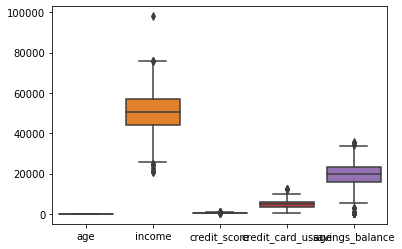

In [61]:
sns.boxplot(data=data);

In [62]:
# income
Q1 = data['income'].quantile(0.25)
Q3 = data['income'].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

data['income'][data['income'] < alt_sinir] = alt_sinir
data['income'][data['income'] > ust_sinir] = ust_sinir

# credit_score
Q1 = data['credit_score'].quantile(0.25)
Q3 = data['credit_score'].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

data['credit_score'][data['credit_score'] < alt_sinir] = alt_sinir
data['credit_score'][data['credit_score'] > ust_sinir] = ust_sinir


# credit_card_usage
Q1 = data['credit_card_usage'].quantile(0.25)
Q3 = data['credit_card_usage'].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

data['credit_card_usage'][data['credit_card_usage'] < alt_sinir] = alt_sinir
data['credit_card_usage'][data['credit_card_usage'] > ust_sinir] = ust_sinir


# savings_balance
Q1 = data['savings_balance'].quantile(0.25)
Q3 = data['savings_balance'].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

data['savings_balance'][data['savings_balance'] < alt_sinir] = alt_sinir
data['savings_balance'][data['savings_balance'] > ust_sinir] = ust_sinir

C:\Users\murat\AppData\Local\Temp\ipykernel_8528\3137913936.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income'][data['income'] < alt_sinir] = alt_sinir
C:\Users\murat\AppData\Local\Temp\ipykernel_8528\3137913936.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income'][data['income'] > ust_sinir] = ust_sinir
C:\Users\murat\AppData\Local\Temp\ipykernel_8528\3137913936.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

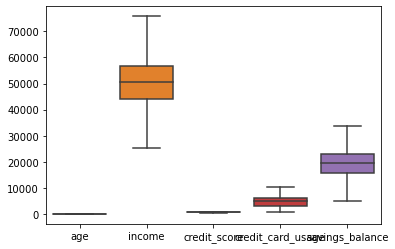

In [63]:
sns.boxplot(data=data);

# Veri Görselleştirme

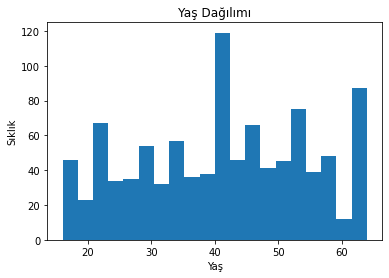

In [64]:
# Yaş Dağılımı
plt.hist(data['age'], bins=20)
plt.title('Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Sıklık')
plt.show()

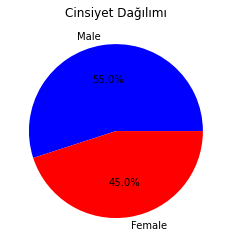

In [65]:
# Cinsiyet Dağılımı

labels = ['Male', 'Female']
sizes = [len(data.loc[data['gender'] == 'male']), len(data.loc[data['gender'] == 'female'])]
colors = ['blue', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Cinsiyet Dağılımı')
plt.show()

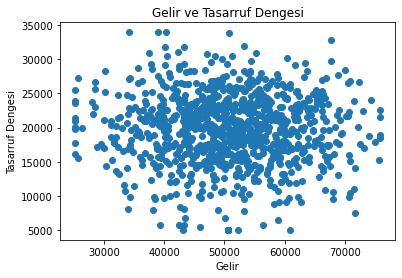

In [66]:
# Gelir ve Tasarruf Dengesi

plt.scatter(data['income'], data['savings_balance'])
plt.title('Gelir ve Tasarruf Dengesi')
plt.xlabel('Gelir')
plt.ylabel('Tasarruf Dengesi')
plt.show()

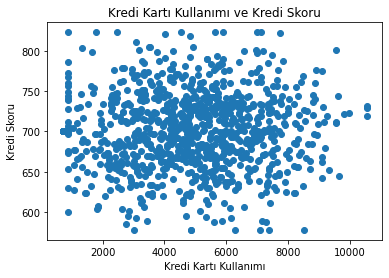

In [67]:
# Kredi Kartı Kullanımı ve Kredi Skoru

plt.scatter(data['credit_card_usage'], data['credit_score'])
plt.title('Kredi Kartı Kullanımı ve Kredi Skoru')
plt.xlabel('Kredi Kartı Kullanımı')
plt.ylabel('Kredi Skoru')
plt.show()

# Model Oluşturma ve Değerlendirme

In [68]:
# Kategorik Değişkeni Numerik değişkene çevirelim.

lbe = LabelEncoder()
data['gender'] = lbe.fit_transform(data['gender'])

In [69]:
# bağımlı ve bağımsız değişkenleri oluşturalım.

X = data.drop('savings_balance', axis=1)
y = data['savings_balance']

In [70]:
# eğitim ve test setlerinin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Model oluşturma, eğitme ve değerlendirme

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} MSE: {mse:.5f}, R-Squared: {r2:.5f}')

Linear Regression MSE: 31841558.65179, R-Squared: 0.08653
Lasso MSE: 31844428.67934, R-Squared: 0.08644
Ridge MSE: 31841876.76570, R-Squared: 0.08652
ElasticNet MSE: 31884604.77367, R-Squared: 0.08529


#### ElasticNet ve Lasso modelleri benzer bir MSE ve R-Kare değeri üretirken, Linear Regression ve Ridge modelleri biraz daha iyi sonuç verdi. Ancak, fark çok büyük değil. En iyi modeli seçmek için, katsayıları ve etkisiz değişkenleri dışlamak için Lasso ve ElasticNet modellerinin kullanılabileceğini unutmamalıyız. R-kare değeri, bağımsız değişkenlerin bağımlı değişkeni ne kadar iyi açıklayabildiğini temsil eder ve 0 ile 1 arasında değer alır. Burada R-kare değerlerini incelediğimiz zaman modellerimiz pek verimli olamadığını görüyoruz. Bu değerlerin sebebi olarak, eksik ve aykırı gözlem analizi, kategorik değişkeni numerik değişkene çevirme aşamasını tekrardan değerlendirmek isteyebiliriz. Eğer sonuç istediğimiz kıvama gelmiyor ise de verilerde bir sorun olduğunu ve model kurmak için yeterince yeterli olmadıklarını düşünebiliriz.

# Model Tuning ve Model Doğrulama

In [72]:
# random_state
random_states = [0, 10, 20, 42, 60, 80, 100]

for element in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'random_state={element} için R-Squared değeri: {r2}')

random_state=0 için R-Squared değeri: 0.07635082921975556
random_state=10 için R-Squared değeri: 0.0649460756071818
random_state=20 için R-Squared değeri: 0.057280015095656056
random_state=42 için R-Squared değeri: 0.08652569694879497
random_state=60 için R-Squared değeri: 0.03280618717329076
random_state=80 için R-Squared değeri: 0.034266827973485015
random_state=100 için R-Squared değeri: 0.09350141666675393


#### En iyi random_state değeri için modelimizi tekrardan oluşturalım.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = Ridge().fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-kare değeri: {r2}')

R-kare değeri: 0.09351440578259584


In [80]:
# GridSearchCV ile hiperparametre ayarı yapalım.

params = {'alpha':[0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), params, cv=5)
grid.fit(X_train, y_train)

print(f'En iyi hiperparametreler: {grid.best_params_}')
print(f'En iyi skor: {grid.best_score_}')

En iyi hiperparametreler: {'alpha': 100}
En iyi skor: 0.04469499150923386


#### En iyi hiperparametre (alpha=100) değerini kullanarak modelimiz tekrardan oluşturacağız.

In [81]:
# model doğrulama işlemi
model = Ridge(alpha=100)
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Ortalama MSE Değeri: {-scores.mean():.5f}')

Ortalama MSE Değeri: 32056378.17327


In [82]:
model = Ridge(alpha=100).fit(X_train, y_train)

# Tahmin

In [83]:
data.head()

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,56.000000,1,44448.004733,638.522520,6738.309185,23357.655859
1,46.000000,0,68811.570694,724.834961,4088.920948,27640.156797
2,41.090526,1,50592.040949,700.920800,700.920800,5076.244958
3,60.000000,0,28011.940434,694.702582,6910.601116,23804.233272
4,41.090526,1,50592.040949,700.920800,700.920800,5076.244958


In [85]:
age = int(input('Yaşınızı Giriniz: '))
gender = input('Cinsiyetinizi Giriniz (Erkek/Kadın): ')
income = float(input('Gelirinizi Giriniz: '))
credit_score = float(input('Kredi Skorunuzu Giriniz: '))
credit_card_usage = float(input('Kredi Kartı Kullanım Değerinizi Giriniz: '))

if gender == 'Erkek':
    predict = model.predict([[age, 1, income, credit_score, credit_card_usage]])
    print('Tahmini tasarruf dengeniz: ', int(predict))
elif gender == 'Kadın':
    predict = model.predict([[age, 0, income, credit_score, credit_card_usage]])
    print('Tahmini tasarruf dengeniz: ', int(predict))

Yaşınızı Giriniz:  23
Cinsiyetinizi Giriniz (Erkek/Kadın):  Erkek
Gelirinizi Giriniz:  15000
Kredi Skorunuzu Giriniz:  659
Kredi Kartı Kullanım Değerinizi Giriniz:  6500


Tahmini tasarruf dengeniz:  20441


C:\Users\murat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


# Sonuç 

### Model değerlendirme kısmında modellerimizin R-kare değerleri modellerimizin yeterince iyi olmadığını göstermişti. Ortalama kare hata değerlerimiz oldukça yüksek çıktı ve model tuning, model doğrulama işlemlerine rağmen istediğimiz seviyeye getiremedik. Fakat, üzerinde çalıştığımız veri setini kendimiz oluşturduk ve rastgele veriler ile doldurduk. Bu yüzden yaptığımız model gerçek hayatı temsil etmiyor. Gerçek hayatta karşılaştığımız bir veri setinden bu sonuçları alsaydık bile daha iyi sonuçlar için veriler üzerinde çalışmaya devam ederdik. 